In [201]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [202]:
WINDOW_SIZE = 20

In [203]:
falls_path = Path('WEDA-FALL/dataset/fall_timestamps.csv')
falls_df = pd.read_csv(falls_path)
falls_df.head()

,filename,start_time,end_time
0,F01/U01_R01,4.7,7.7
1,F01/U01_R02,4.7,7.7
2,F01/U01_R03,5.0,8.0
3,F02/U01_R01,5.1,8.1
4,F02/U01_R02,5.7,8.7


In [204]:
dataset = Path('WEDA-FALL/dataset/50Hz')
p_accel = (f for f in dataset.glob('F*/*_accel.csv') if 'vertical' not in f.name)
p_gyro = dataset.glob('F*/*_gyro.csv')

In [205]:
def complementary_filter(df):
	"""
	Vectorized implementation using cumsum.
	Most efficient for large datasets.
	"""
	pitch = np.atan2(
		-df['accel_x_list'], np.sqrt(df['accel_y_list'] ** 2 + df['accel_z_list'] ** 2)
	) * (180 / np.pi)
	# Calculate gyro integration term
	gyro_integration = df['gyro_y_list'] * (1 / 50)

	# Calculate the recursive component using cumsum
	# This handles: 0.98 * (previous_angle + gyro_term)
	recursive_term = (0.98 * gyro_integration).cumsum()

	# Add the accelerometer correction term
	accel_term = 0.02 * pitch

	# Combine terms (note: first value needs special handling)
	df['angle_pitch'] = recursive_term + accel_term.cumsum()

	# Handle the initial condition if needed
	# df['angle_pitch'].iloc[0] = initial_value  # Set your initial value

	return df

In [206]:
# def preprocess_df(df):
# 	df['acceleration'] = np.sqrt(
# 		df['accel_x_list'] ** 2 + df['accel_y_list'] ** 2 + df['accel_z_list'] ** 2
# 	)
# 	df['rotationrate'] = np.sqrt(
# 		df['gyro_x_list'] ** 2 + df['gyro_y_list'] ** 2 + df['gyro_z_list'] ** 2
# 	)
# 	df = complementary_filter(df)
# 	df = df.filter(
# 		items=['accel_time_list', 'gyro_time_list', 'acceleration', 'rotationrate', 'angle_pitch']
# 	)
# 	df['acceleration'] = df['acceleration'].rolling(window=WINDOW_SIZE).mean()
# 	df['rotationrate'] = df['rotationrate'].rolling(window=WINDOW_SIZE).mean()
# 	return df

In [207]:
def preprocess_df(df):
	df['acceleration'] = np.sqrt(
		df['accel_x_list'] ** 2 + df['accel_y_list'] ** 2 + df['accel_z_list'] ** 2
	)
	df['rotationrate'] = np.sqrt(
		df['gyro_x_list'] ** 2 + df['gyro_y_list'] ** 2 + df['gyro_z_list'] ** 2
	)

	df['acceleration'] = df['acceleration'].rolling(window=WINDOW_SIZE).mean()
	df['rotationrate'] = df['rotationrate'].rolling(window=WINDOW_SIZE).mean()

	pitch = np.atan2(
		-df['accel_x_list'], np.sqrt(df['accel_y_list'] ** 2 + df['accel_z_list'] ** 2)
	) * (180 / np.pi)
	gyro_integration = df['gyro_y_list'] * (1 / 50)

	# Calculate the recursive component using cumsum
	# This handles: 0.98 * (previous_angle + gyro_term)
	recursive_term = (0.98 * gyro_integration).cumsum()

	# Add the accelerometer correction term
	accel_term = 0.02 * pitch

	# Combine terms (note: first value needs special handling)
	df['angle_pitch'] = recursive_term + accel_term.cumsum()

	df = df.filter(
		items=['accel_time_list', 'gyro_time_list', 'acceleration', 'rotationrate', 'angle_pitch']
	)
	return df

In [208]:
df_list = []
for acc, gyro in zip(p_accel, p_gyro):
	df1 = pd.read_csv(acc)
	df2 = pd.read_csv(gyro)
	df = pd.concat([df1, df2], axis=1)
	df = preprocess_df(df).dropna()
	df_list.append(df)
df = pd.concat(df_list)

In [209]:
split = acc.stem.split('_')
filename = str(acc.parent.name + '/' + split[0] + '_' + split[1])
falls_df[falls_df['filename'] == filename]
_, start, end = falls_df[falls_df['filename'] == filename].iloc[0]

In [210]:
df['label'] = np.where(
	(df['accel_time_list'] > start)
	& (df['accel_time_list'] < end)
	& (df['gyro_time_list'] > start)
	& (df['gyro_time_list'] < end),
	'fall',
	'ADL',
)

In [212]:
X = df[['acceleration', 'rotationrate', 'angle_pitch']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [224]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ADL       0.74      0.98      0.84     22880
        fall       0.77      0.18      0.29      9743

    accuracy                           0.74     32623
   macro avg       0.75      0.58      0.56     32623
weighted avg       0.75      0.74      0.68     32623



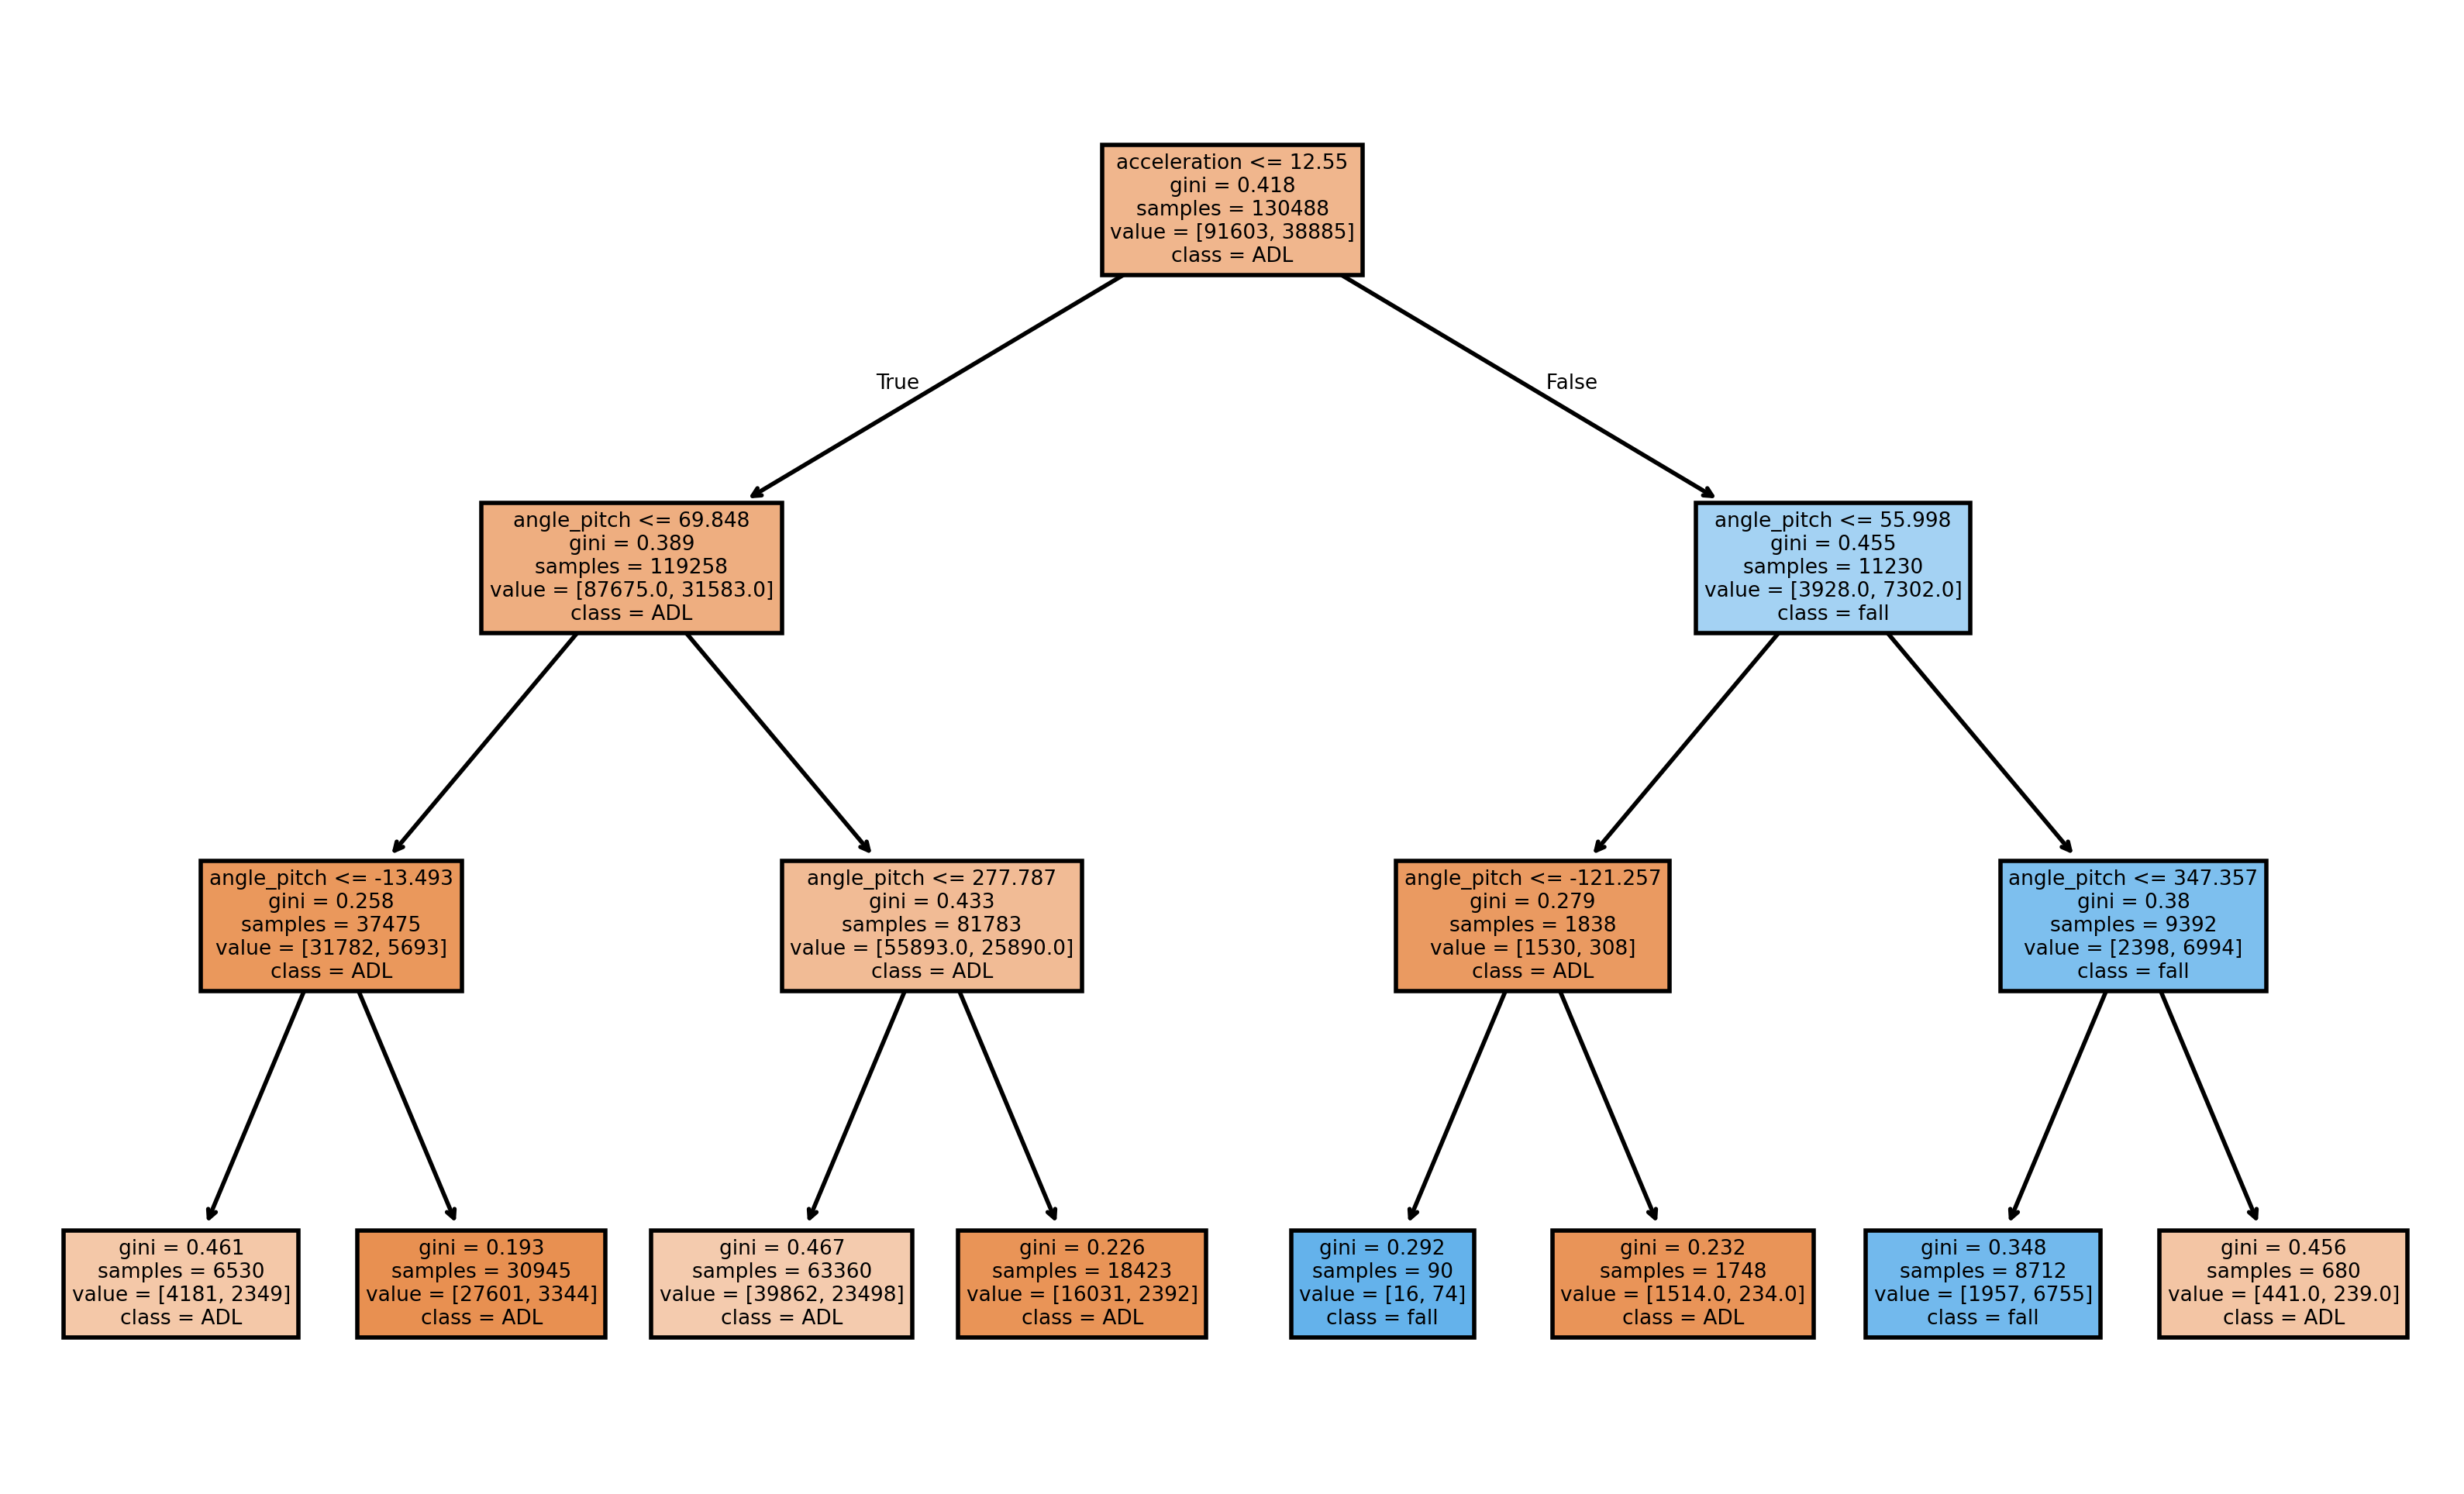

In [225]:
plt.figure(figsize=(10, 6), dpi=400)
plot_tree(clf, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.show()

In [217]:
from sklearn.tree import _tree


def tree_to_rules(clf, feature_names):
	tree_ = clf.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else 'undefined!' for i in tree_.feature
	]

	paths = []

	def recurse(node, path):
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			threshold = float(threshold)
			# left child
			recurse(tree_.children_left[node], path + [(name, '<=', threshold)])
			# right child
			recurse(tree_.children_right[node], path + [(name, '>', threshold)])
		else:
			# leaf node
			value = tree_.value[node]
			class_id = value.argmax()
			paths.append((path, class_id))

	recurse(0, [])
	return paths


# Extract rules
rules = tree_to_rules(clf, X.columns)

# Convert rules to readable intervals
for conditions, class_id in rules:
	cond_str = ', '.join([f'{a} {b} {c:.2f}' for a, b, c in conditions])
	print(f'Class {class_id} :', cond_str)

Class 0 : acceleration <= 12.55, angle_pitch <= 69.85
Class 0 : acceleration <= 12.55, angle_pitch > 69.85
Class 0 : acceleration > 12.55, angle_pitch <= 56.00
Class 1 : acceleration > 12.55, angle_pitch > 56.00


In [218]:
df.columns

Index(['accel_time_list', 'gyro_time_list', 'acceleration', 'rotationrate',
       'angle_pitch', 'label'],
      dtype='object')

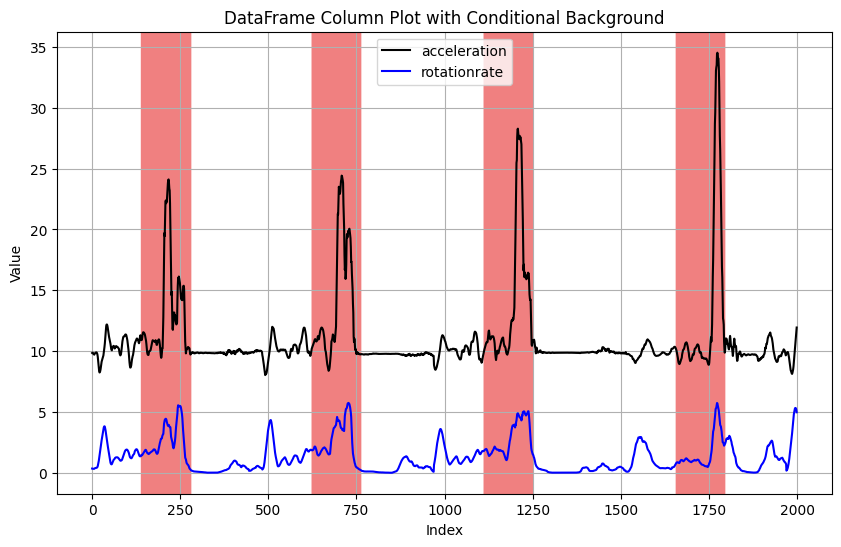

In [227]:
start = 0
lenn = start + 2000

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))
df[['acceleration', 'rotationrate']][start:lenn].reset_index(drop=True).plot(
	ax=ax, color=['black', 'blue']
)
ax.set_title('DataFrame Column Plot with Conditional Background')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

# Add conditional background color
for i, label in enumerate(df['label'][start:lenn]):
	if label == 'fall':
		ax.axvspan(i, i + 1, color='lightcoral')

plt.grid()
plt.show()